In [62]:
import pickle

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split
import seaborn as sns

## Data Preperation

In [48]:
df = pd.read_csv('diabetes.csv')

In [49]:
df.columns = df.columns.str.lower().str.replace(' ','_')


categorical = ['gender']
## Can be converted to numerical
ctegorical_numerical = ['polyuria','polydipsia','sudden_weight_loss','weakness','polyphagia','genital_thrush','visual_blurring','itching',
        'irritability','delayed_healing','partial_paresis','muscle_stiffness','alopecia','obesity']
numerical = ['age']

df.head()

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [50]:
df.gender.value_counts()

Male      317
Female    188
Binary     15
Name: gender, dtype: int64

In [51]:
for cat in ctegorical_numerical:
    df[cat] = (df[cat] == 'Yes').values.astype(int)

In [52]:
df['class'] = (df['class'] == 'Positive').values.astype(int)
df

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,Male,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,Male,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,Male,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,Male,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,Male,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,48,Binary,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
517,58,Female,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
518,32,Female,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0


In [53]:
numerical += ctegorical_numerical

## EDA

In [60]:
df.describe()

,age,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,48.028846,0.496154,0.448077,0.417308,0.586538,0.455769,0.223077,0.448077,0.486538,0.242308,0.459615,0.430769,0.375000,0.344231,0.169231,0.615385
std,12.151466,0.500467,0.497776,0.493589,0.492928,0.498519,0.416710,0.497776,0.500300,0.428892,0.498846,0.495661,0.484589,0.475574,0.375317,0.486973
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,57.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
### Check null values

df.isnull().sum()

age                   0
gender                0
polyuria              0
polydipsia            0
sudden_weight_loss    0
weakness              0
polyphagia            0
genital_thrush        0
visual_blurring       0
itching               0
irritability          0
delayed_healing       0
partial_paresis       0
muscle_stiffness      0
alopecia              0
obesity               0
class                 0
dtype: int64

In [63]:
corr_matrix = df.corr()
corr_matrix

,age,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
age,1.000000,0.199781,0.137382,0.064808,0.224596,0.315577,0.096519,0.402729,0.296559,0.201625,0.257501,0.232742,0.307703,0.321691,0.140458,0.108679
polyuria,0.199781,1.000000,0.598609,0.447207,0.263000,0.373873,0.087273,0.235095,0.088289,0.237740,0.149873,0.441664,0.152938,-0.144192,0.126567,0.665922
polydipsia,0.137382,0.598609,1.000000,0.405965,0.332453,0.316839,0.028081,0.331250,0.128716,0.203446,0.115691,0.442249,0.180723,-0.310964,0.098691,0.648734
sudden_weight_loss,0.064808,0.447207,0.405965,1.000000,0.282884,0.243511,0.089858,0.068754,-0.004516,0.140340,0.088140,0.264014,0.109756,-0.202727,0.169294,0.436568
weakness,0.224596,0.263000,0.332453,0.282884,1.000000,0.180266,0.027780,0.301043,0.309440,0.146698,0.335507,0.272982,0.263164,0.090490,0.045665,0.243275
polyphagia,0.315577,0.373873,0.316839,0.243511,0.180266,1.000000,-0.063712,0.293545,0.144390,0.239466,0.263980,0.373569,0.320031,-0.053498,0.029785,0.342504
genital_thrush,0.096519,0.087273,0.028081,0.089858,0.027780,-0.063712,1.000000,-0.148408,0.125336,0.160551,0.136111,-0.195612,-0.100188,0.204847,0.053828,0.110288
visual_blurring,0.402729,0.235095,0.331250,0.068754,0.301043,0.293545,-0.148408,1.000000,0.291191,0.077095,0.177767,0.364156,0.412369,0.014604,0.109005,0.251300
itching,0.296559,0.088289,0.128716,-0.004516,0.309440,0.144390,0.125336,0.291191,1.000000,0.114006,0.453316,0.116669,0.215575,0.266506,0.001894,-0.013384
irritability,0.201625,0.237740,0.203446,0.140340,0.146698,0.239466,0.160551,0.077095,0.114006,1.000000,0.126877,0.151571,0.201637,0.043708,0.127801,0.299467


### Correlations Can be seen better in heatmap plot

<AxesSubplot:>

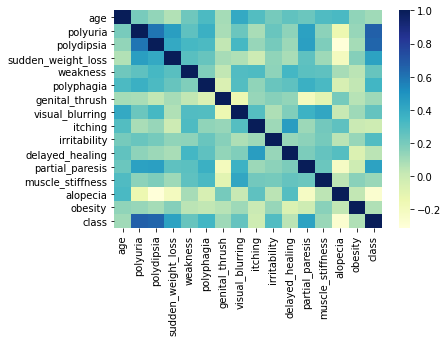

In [66]:
sns.heatmap(corr_matrix, cmap="YlGnBu")

In [72]:
df.corrwith(df['class']).sort_values(ascending=False)

class                 1.000000
polyuria              0.665922
polydipsia            0.648734
sudden_weight_loss    0.436568
partial_paresis       0.432288
polyphagia            0.342504
irritability          0.299467
visual_blurring       0.251300
weakness              0.243275
muscle_stiffness      0.122474
genital_thrush        0.110288
age                   0.108679
obesity               0.072173
delayed_healing       0.046980
itching              -0.013384
alopecia             -0.267512
dtype: float64

## Model Selection

#### polyuria disease is the most affective on the Diabeties

In [73]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}


##### Train function
def train(df_train, y_train, xgb_params=xgb_params):
    dicts = df_train[categorical + numerical].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    features = dv.get_feature_names()
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)

    model = xgb.train(xgb_params, dtrain, num_boost_round=65)

    return dv, model

#### Prediction function
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")

    X = dv.transform(dicts)
    dX = xgb.DMatrix(X, feature_names=dv.get_feature_names())
    y_pred = model.predict(dX)

    return y_pred

In [76]:
################################ Train And try KFold Cross Validation ################################

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

n_splits = 5
print('Validating ...')

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

fold = 0

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['class'].values
    y_val = df_val['class'].values

    dv, model = train(df_train, y_train, xgb_params)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

    print(f"auc on fold {fold} is {auc}")
    fold = fold + 1


print("validation results:")
print("%.3f +- %.3f" % (np.mean(scores), np.std(scores)))

Validating ...
auc on fold 0 is 0.9764030612244898
auc on fold 1 is 0.9692671394799055
auc on fold 2 is 0.9963985594237694
auc on fold 3 is 0.992797118847539
auc on fold 4 is 0.9949685534591195
validation results:
0.986 +- 0.011


In [78]:
dv.feature_names_

['age',
 'alopecia',
 'delayed_healing',
 'gender=Binary',
 'gender=Female',
 'gender=Male',
 'genital_thrush',
 'irritability',
 'itching',
 'muscle_stiffness',
 'obesity',
 'partial_paresis',
 'polydipsia',
 'polyphagia',
 'polyuria',
 'sudden_weight_loss',
 'visual_blurring',
 'weakness']

### There is no need to try different options for xgboost because results are awesome!